In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [3]:
df_raw = pd.read_excel('./Data_Processed_All_Contractors_Characteristics.xlsx',sheet=1)

In [4]:
df_raw.shape

(5046, 77)

In [5]:
columns_list = list(df_raw.columns)

In [6]:
df_raw.columns

Index(['Dealer ID', 'year', 'train_test', 'Converted State-AL',
       'Converted State-AR', 'Converted State-CA', 'Converted State-FL',
       'Converted State-GA', 'Converted State-IL', 'Converted State-IN',
       'Converted State-KY', 'Converted State-LA', 'Converted State-MI',
       'Converted State-MO', 'Converted State-NC', 'Converted State-NJ',
       'Converted State-OH', 'Converted State-Others', 'Converted State-PA',
       'Converted State-SC', 'Converted State-TN', 'Converted State-TX',
       'employeebucket-NA', 'employeebucket-4~8', 'employeebucket-<4',
       'employeebucket->8', 'No. of Employees', 'Sales between 0-99,999',
       'Sales between 100,000-499,999', 'Other Sales', 'Sales N/A',
       'Currently offers Consumer Financing?_No',
       'Currently offers Consumer Financing?_Yes',
       'Currently offers Consumer Financing?_N/A', 'Over 10', 'Below 10',
       'No year info', 'Gibson 18.Column3', 'Hitting Potential 16.Column3',
       'JS 16.Column3', 'JS 17

In [7]:
def find_index(name):
    index_num = columns_list.index(name)
    print(index_num)

# 2016 Register to Apply (SVM)

In [8]:
find_index('applied 2016')

56


In [9]:
df_2016 = df_raw.loc[df_raw['year'] == 2016]

In [10]:
df_2016_xy = df_2016.iloc[:,:57].drop(['Dealer ID','No. of Employees','year','JS 17.Column3','JS 18.Column3','JS 19.Column3','NON USER 17.Column3','NON USER 18.Column3','Velocity 17.Column3','centurty 18.Column3','Gibson 18.Column3'],axis=1)

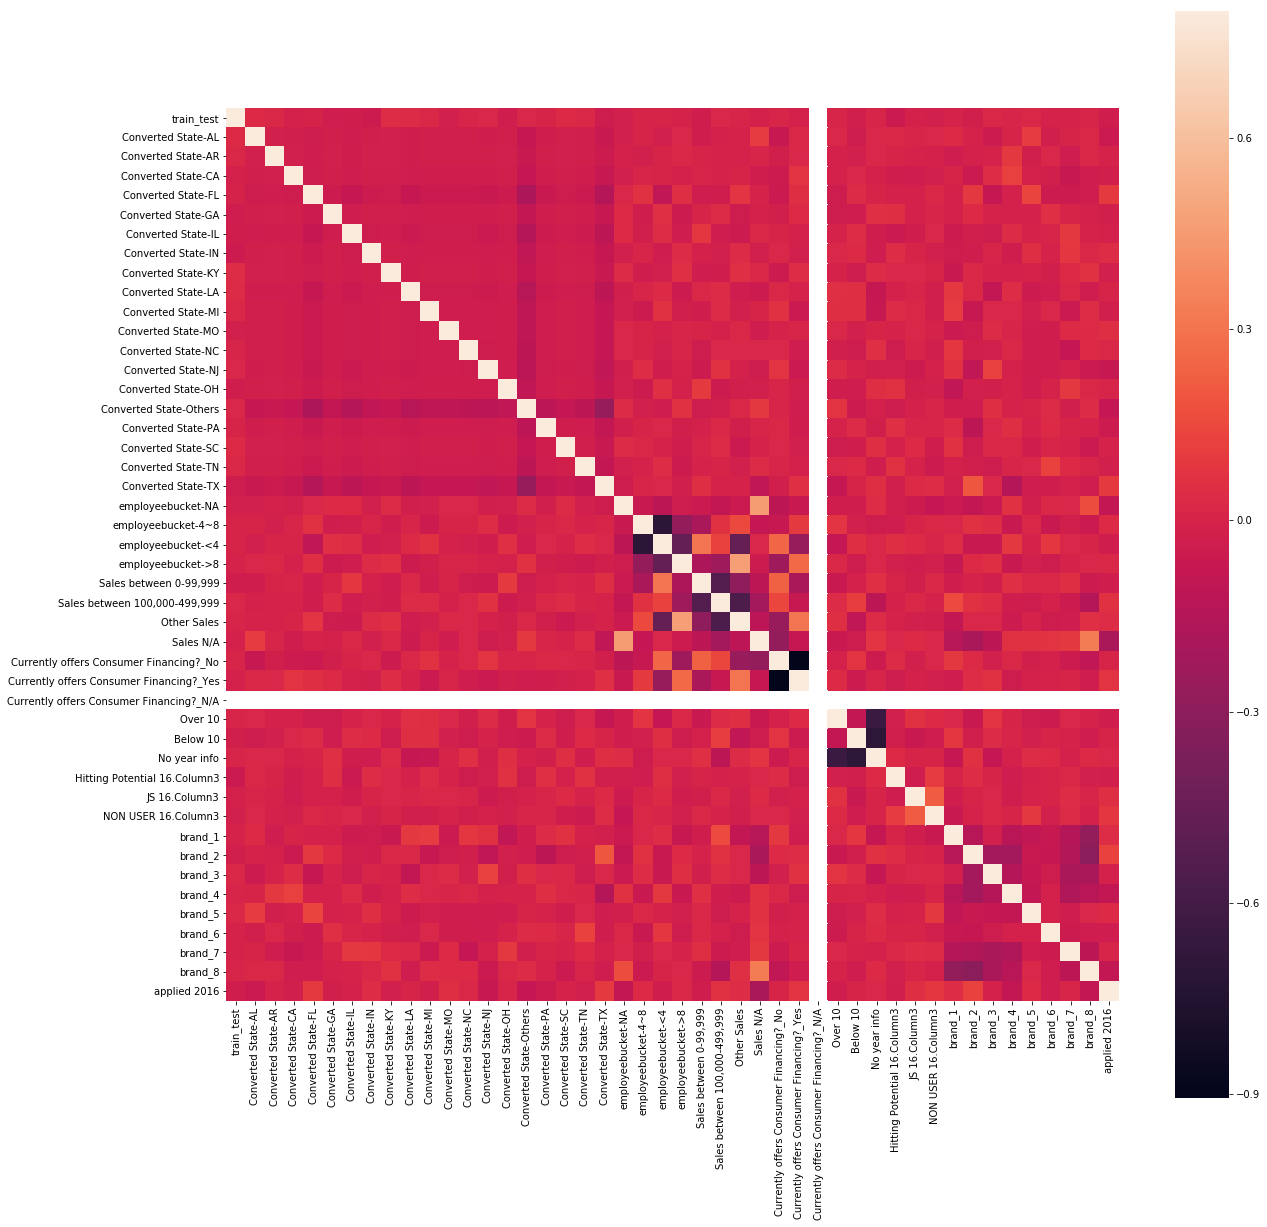

In [11]:
corr = df_2016_xy.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, vmax=.8, square=True)
plt.show()

In [12]:
train_df = df_2016_xy.loc[df_2016_xy['train_test'] == 1].drop('train_test',axis = 1)
test_df = df_2016_xy.loc[df_2016_xy['train_test'] == 0].drop('train_test',axis = 1)
x_train = train_df.iloc[:,:44].values
y_train = train_df['applied 2016'].values
x_test = test_df.iloc[:,:44]
y_test = test_df['applied 2016'].values
# scaler = StandardScaler()
# x_std = scaler.fit_transform(x)

In [13]:
def svm(x_train,y_train,x_test,y_test, kernel_name='rbf', c_base = 2, gamma_base = 2,grid_cv_num = 5):
    svc = SVC(kernel=kernel_name, class_weight = 'balanced',probability=True)
    c_range = np.logspace(-2,4,10,base=c_base)
    gamma_range = np.logspace(-2,4,10,base=gamma_base)
    param_grid = [{'kernel':[kernel_name],'C':c_range,'gamma':gamma_range}]
    grid = GridSearchCV(svc,param_grid,cv=grid_cv_num,n_jobs=-1,verbose=1)
    clf = grid.fit(x_train,y_train)
    print("Best: %f using %s" % (clf.best_score_,clf.best_params_))
    pred = clf.predict(x_test)
    pred_prob = clf.predict_proba(x_test)
    pred_prob = [i[1] for i in pred_prob]
    matrix = confusion_matrix(y_test, pred, labels=None, sample_weight=None)
    score = grid.score(x_test,y_test)
    print('accuracy:{}'.format(score))
    return pred,pred_prob,matrix

In [14]:
pred,pred_prob,matrix = svm(x_train,y_train,x_test,y_test,'linear')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   27.8s finished


Best: 0.571307 using {'C': 0.25, 'gamma': 0.25, 'kernel': 'linear'}
accuracy:0.5966101694915255


In [15]:
def metrix_matrix(matrix):
    df_matrix=pd.DataFrame(matrix,columns=['pred_0','pred_1'],index=['actual_0','actual_1'])
    tn, fp, fn, tp=matrix.ravel()
    acc=(tp+tn)/(tp+tn+fp+fn)
    ppv=tp/(tp+fp)
    npv=tn/(tn+fn)
    tpr=tp/(tp+fn)
    tnr=tn/(tn+fp)
    summary_matrix=[acc,ppv,npv,tpr,tnr]
    df_summary=pd.DataFrame(summary_matrix,columns=['Value'],index=['Accuracy','PPV','NPV','Sensitivity','Specificity'])
    return df_matrix,df_summary

In [16]:
df_matrix,df_summary = metrix_matrix(matrix)

In [17]:
df_matrix

,pred_0,pred_1
actual_0,70,65
actual_1,54,106


In [18]:
df_summary

,Value
Accuracy,0.596610
PPV,0.619883
NPV,0.564516
Sensitivity,0.662500
Specificity,0.518519


In [19]:
contractor_id = df_2016.loc[(df_2016['train_test'] == 0),'Dealer ID'].values
actual = y_test
predicted_prob = np.array(pred_prob)
predicted= pred

In [20]:
df_result=pd.DataFrame()
df_result["contractor_id"]=contractor_id
df_result["actual"]=actual
df_result["predicted"]=predicted
df_result["predicted_prob"]=predicted_prob

In [21]:
def TP(columna,columnb):
    if columna==1 and columnb==1:
        x=1
    else:
        x=0
    return x

In [22]:
df_result=df_result.sort_values(by=["predicted_prob"],ascending=False)
df_result["Actual_Positive"]=df_result.apply(lambda x: TP(x["actual"],x["predicted"]),axis=1)
df_result["Cumulative_Positives"]=df_result["Actual_Positive"].cumsum()
total_positives=df_result["Actual_Positive"].sum()
df_result["Cumulative_Positives_percent"]=df_result["Cumulative_Positives"]/total_positives
df_result["Cumulative_Count"]=df_result["contractor_id"].expanding().count()/df_result["contractor_id"].count()

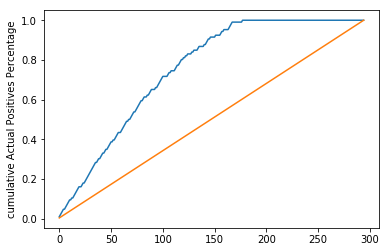

In [23]:
plt.plot(df_result["Cumulative_Positives_percent"].values.tolist())
plt.plot(df_result["Cumulative_Count"].values.tolist())
plt.ylabel('cumulative Actual Positives Percentage')

plt.show()

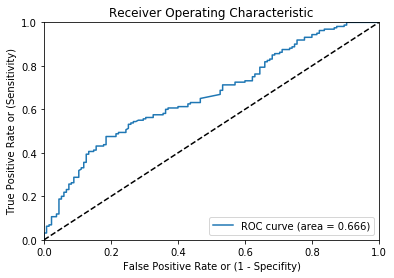

In [24]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(actual, predicted_prob,1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# 2017 Register to Apply (SVM)

In [25]:
find_index('applied 2017')

57


In [26]:
df_2017 = df_raw.loc[df_raw['year'] == 2017]

In [27]:
df_2017_xy = df_2017.iloc[:,:58].drop(['Dealer ID','No. of Employees','year','applied 2016','JS 16.Column3','JS 18.Column3','JS 19.Column3','NON USER 16.Column3','NON USER 18.Column3','centurty 18.Column3','Gibson 18.Column3','Hitting Potential 16.Column3'],axis=1)

In [28]:
train_df = df_2017_xy.loc[df_2017_xy['train_test'] == 1].drop('train_test',axis = 1)
test_df = df_2017_xy.loc[df_2017_xy['train_test'] == 0].drop('train_test',axis = 1)
x_train = train_df.iloc[:,:44].values
y_train = train_df['applied 2017'].values
x_test = test_df.iloc[:,:44]
y_test = test_df['applied 2017'].values
# scaler = StandardScaler()
# x_std = scaler.fit_transform(x)

In [29]:
pred,pred_prob,matrix = svm(x_train,y_train,x_test,y_test,'linear')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.6s finished


Best: 0.519270 using {'C': 0.39685026299204984, 'gamma': 0.25, 'kernel': 'linear'}
accuracy:0.6275303643724697


In [30]:
df_matrix,df_summary = metrix_matrix(matrix)

In [31]:
df_matrix

,pred_0,pred_1
actual_0,76,50
actual_1,42,79


In [32]:
df_summary

,Value
Accuracy,0.627530
PPV,0.612403
NPV,0.644068
Sensitivity,0.652893
Specificity,0.603175


In [33]:
contractor_id = df_2017.loc[(df_2017['train_test'] == 0),'Dealer ID'].values
actual = y_test
predicted_prob = np.array(pred_prob)
predicted= pred

In [34]:
df_result=pd.DataFrame()
df_result["contractor_id"]=contractor_id
df_result["actual"]=actual
df_result["predicted"]=predicted
df_result["predicted_prob"]=predicted_prob

In [35]:
df_result=df_result.sort_values(by=["predicted_prob"],ascending=False)
df_result["Actual_Positive"]=df_result.apply(lambda x: TP(x["actual"],x["predicted"]),axis=1)
df_result["Cumulative_Positives"]=df_result["Actual_Positive"].cumsum()
total_positives=df_result["Actual_Positive"].sum()
df_result["Cumulative_Positives_percent"]=df_result["Cumulative_Positives"]/total_positives
df_result["Cumulative_Count"]=df_result["contractor_id"].expanding().count()/df_result["contractor_id"].count()

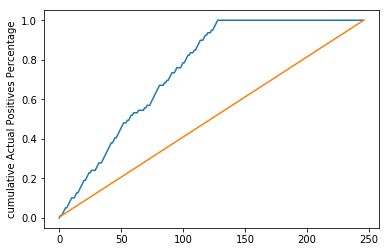

In [36]:
plt.plot(df_result["Cumulative_Positives_percent"].values.tolist())
plt.plot(df_result["Cumulative_Count"].values.tolist())
plt.ylabel('cumulative Actual Positives Percentage')

plt.show()

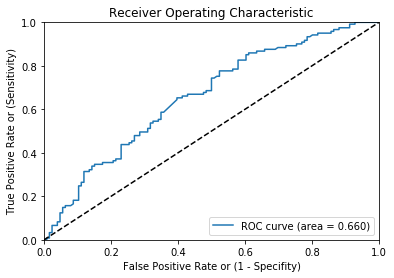

In [37]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(actual, predicted_prob,1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Window 1 Year (SVM)

In [38]:
find_index('applied_in_window_12months_or_not')

73


In [39]:
df_window_one_year = df_raw.loc[df_raw['applied_in_window_12months_or_not'] != 'Not enough info']

In [40]:
x_train = df_window_one_year.loc[df_raw['train_test'] == 1].iloc[:,:56].drop(['Dealer ID','year','train_test','No. of Employees'],axis=1).values
y_train = df_window_one_year.loc[df_raw['train_test'] == 1].iloc[:,73].astype(int).values
x_test = df_window_one_year.loc[df_raw['train_test'] == 0].iloc[:,:56].drop(['Dealer ID','year','train_test','No. of Employees'],axis=1).values
y_test = df_window_one_year.loc[df_raw['train_test'] == 0].iloc[:,73].astype(int).values

In [41]:
pred,pred_prob,matrix = svm(x_train,y_train,x_test,y_test,'linear')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.7min finished


Best: 0.569135 using {'C': 6.349604207872796, 'gamma': 0.25, 'kernel': 'linear'}
accuracy:0.635890767230169


In [42]:
df_matrix,df_summary = metrix_matrix(matrix)

In [43]:
df_matrix

,pred_0,pred_1
actual_0,154,142
actual_1,138,335


In [44]:
df_summary

,Value
Accuracy,0.635891
PPV,0.702306
NPV,0.527397
Sensitivity,0.708245
Specificity,0.520270


In [45]:
contractor_id = df_window_one_year.loc[(df_window_one_year['train_test'] == 0),'Dealer ID'].values
actual = y_test
predicted_prob = np.array(pred_prob)
predicted= pred

In [46]:
df_result=pd.DataFrame()
df_result["contractor_id"]=contractor_id
df_result["actual"]=actual
df_result["predicted"]=predicted
df_result["predicted_prob"]=predicted_prob

In [47]:
df_result=df_result.sort_values(by=["predicted_prob"],ascending=False)
df_result["Actual_Positive"]=df_result.apply(lambda x: TP(x["actual"],x["predicted"]),axis=1)
df_result["Cumulative_Positives"]=df_result["Actual_Positive"].cumsum()
total_positives=df_result["Actual_Positive"].sum()
df_result["Cumulative_Positives_percent"]=df_result["Cumulative_Positives"]/total_positives
df_result["Cumulative_Count"]=df_result["contractor_id"].expanding().count()/df_result["contractor_id"].count()

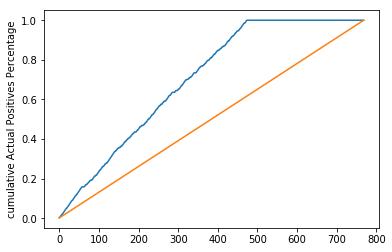

In [48]:
plt.plot(df_result["Cumulative_Positives_percent"].values.tolist())
plt.plot(df_result["Cumulative_Count"].values.tolist())
plt.ylabel('cumulative Actual Positives Percentage')

plt.show()

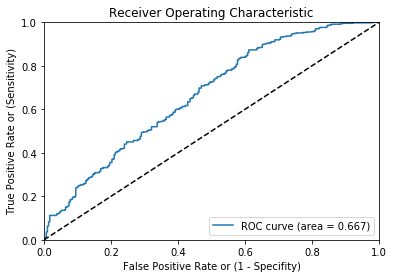

In [49]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(actual, predicted_prob,1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")